# Action Recognition Modelling and Evaluation

Author: Liam Moorfield-Yee

Date: 05-27-2023

This notebook aims to train various models to recognize the below six unique actions.

1. Wave
2. Finger 
3. Salute
4. Kiss
5. Heart
6. Idle

Each observation in our data is a video with a length of 40 frames. Due to the sequential nature of videos a Long Short-Term Memory (LSTM) Neural Network is trained and deployed due to its ability to retain information from previously seen data. This enables the model to consider the entire 40 frames in each video when making a classification.

This notebook picks up after the Data Wrangling and EDA book.

#### Load in Data

In [1]:
# import dependencies
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score,accuracy_score, roc_curve, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
import keras
import os
import numpy as np
from keypoints import Pipe
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# import data
lh_df = pd.read_csv('./Modelling_Data/left_hand.csv', index_col=0)
rh_df = pd.read_csv('./Modelling_Data/right_hand.csv', index_col=0)
pose_df = pd.read_csv('./Modelling_Data/pose.csv', index_col=0)
face_df = pd.read_csv('./Modelling_Data/face.csv', index_col=0)
lm_distances = pd.read_csv('./Modelling_Data/lm_distances.csv', index_col=0)

In [3]:
# Quick peak at the data to make sure it loaded correctly
lh_df.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,action,video sample number,frame number
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,finger,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,finger,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,finger,0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,finger,0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,finger,0,4


In [4]:
# create label map for when we convert our data back into a 3D numpy array
# set path to saved data
data_path = "./Processed_Data"

# get list of all detected actions
action_list = os.listdir(data_path)

# create a mapping dict to detected action
label_map = {label: num for num, label in enumerate(action_list)}

## LSTM Neural Network - All Landmark Location Data

First model we'll build will be trained on only the location data of the body landmarks. The 4 landmark location dataframes need to be merged. We need to drop the classification columns first (action, video sample number, and frame number cols).

### Hand Landmark List

![Alt text](https://camo.githubusercontent.com/b0f077393b25552492ef5dd7cd9fd13f386e8bb480fa4ed94ce42ede812066a1/68747470733a2f2f6d65646961706970652e6465762f696d616765732f6d6f62696c652f68616e645f6c616e646d61726b732e706e67)

### Pose Landmark List
![Alt text](https://camo.githubusercontent.com/7fbec98ddbc1dc4186852d1c29487efd7b1eb820c8b6ef34e113fcde40746be2/68747470733a2f2f6d65646961706970652e6465762f696d616765732f6d6f62696c652f706f73655f747261636b696e675f66756c6c5f626f64795f6c616e646d61726b732e706e67)

### Face Mesh Landmark List

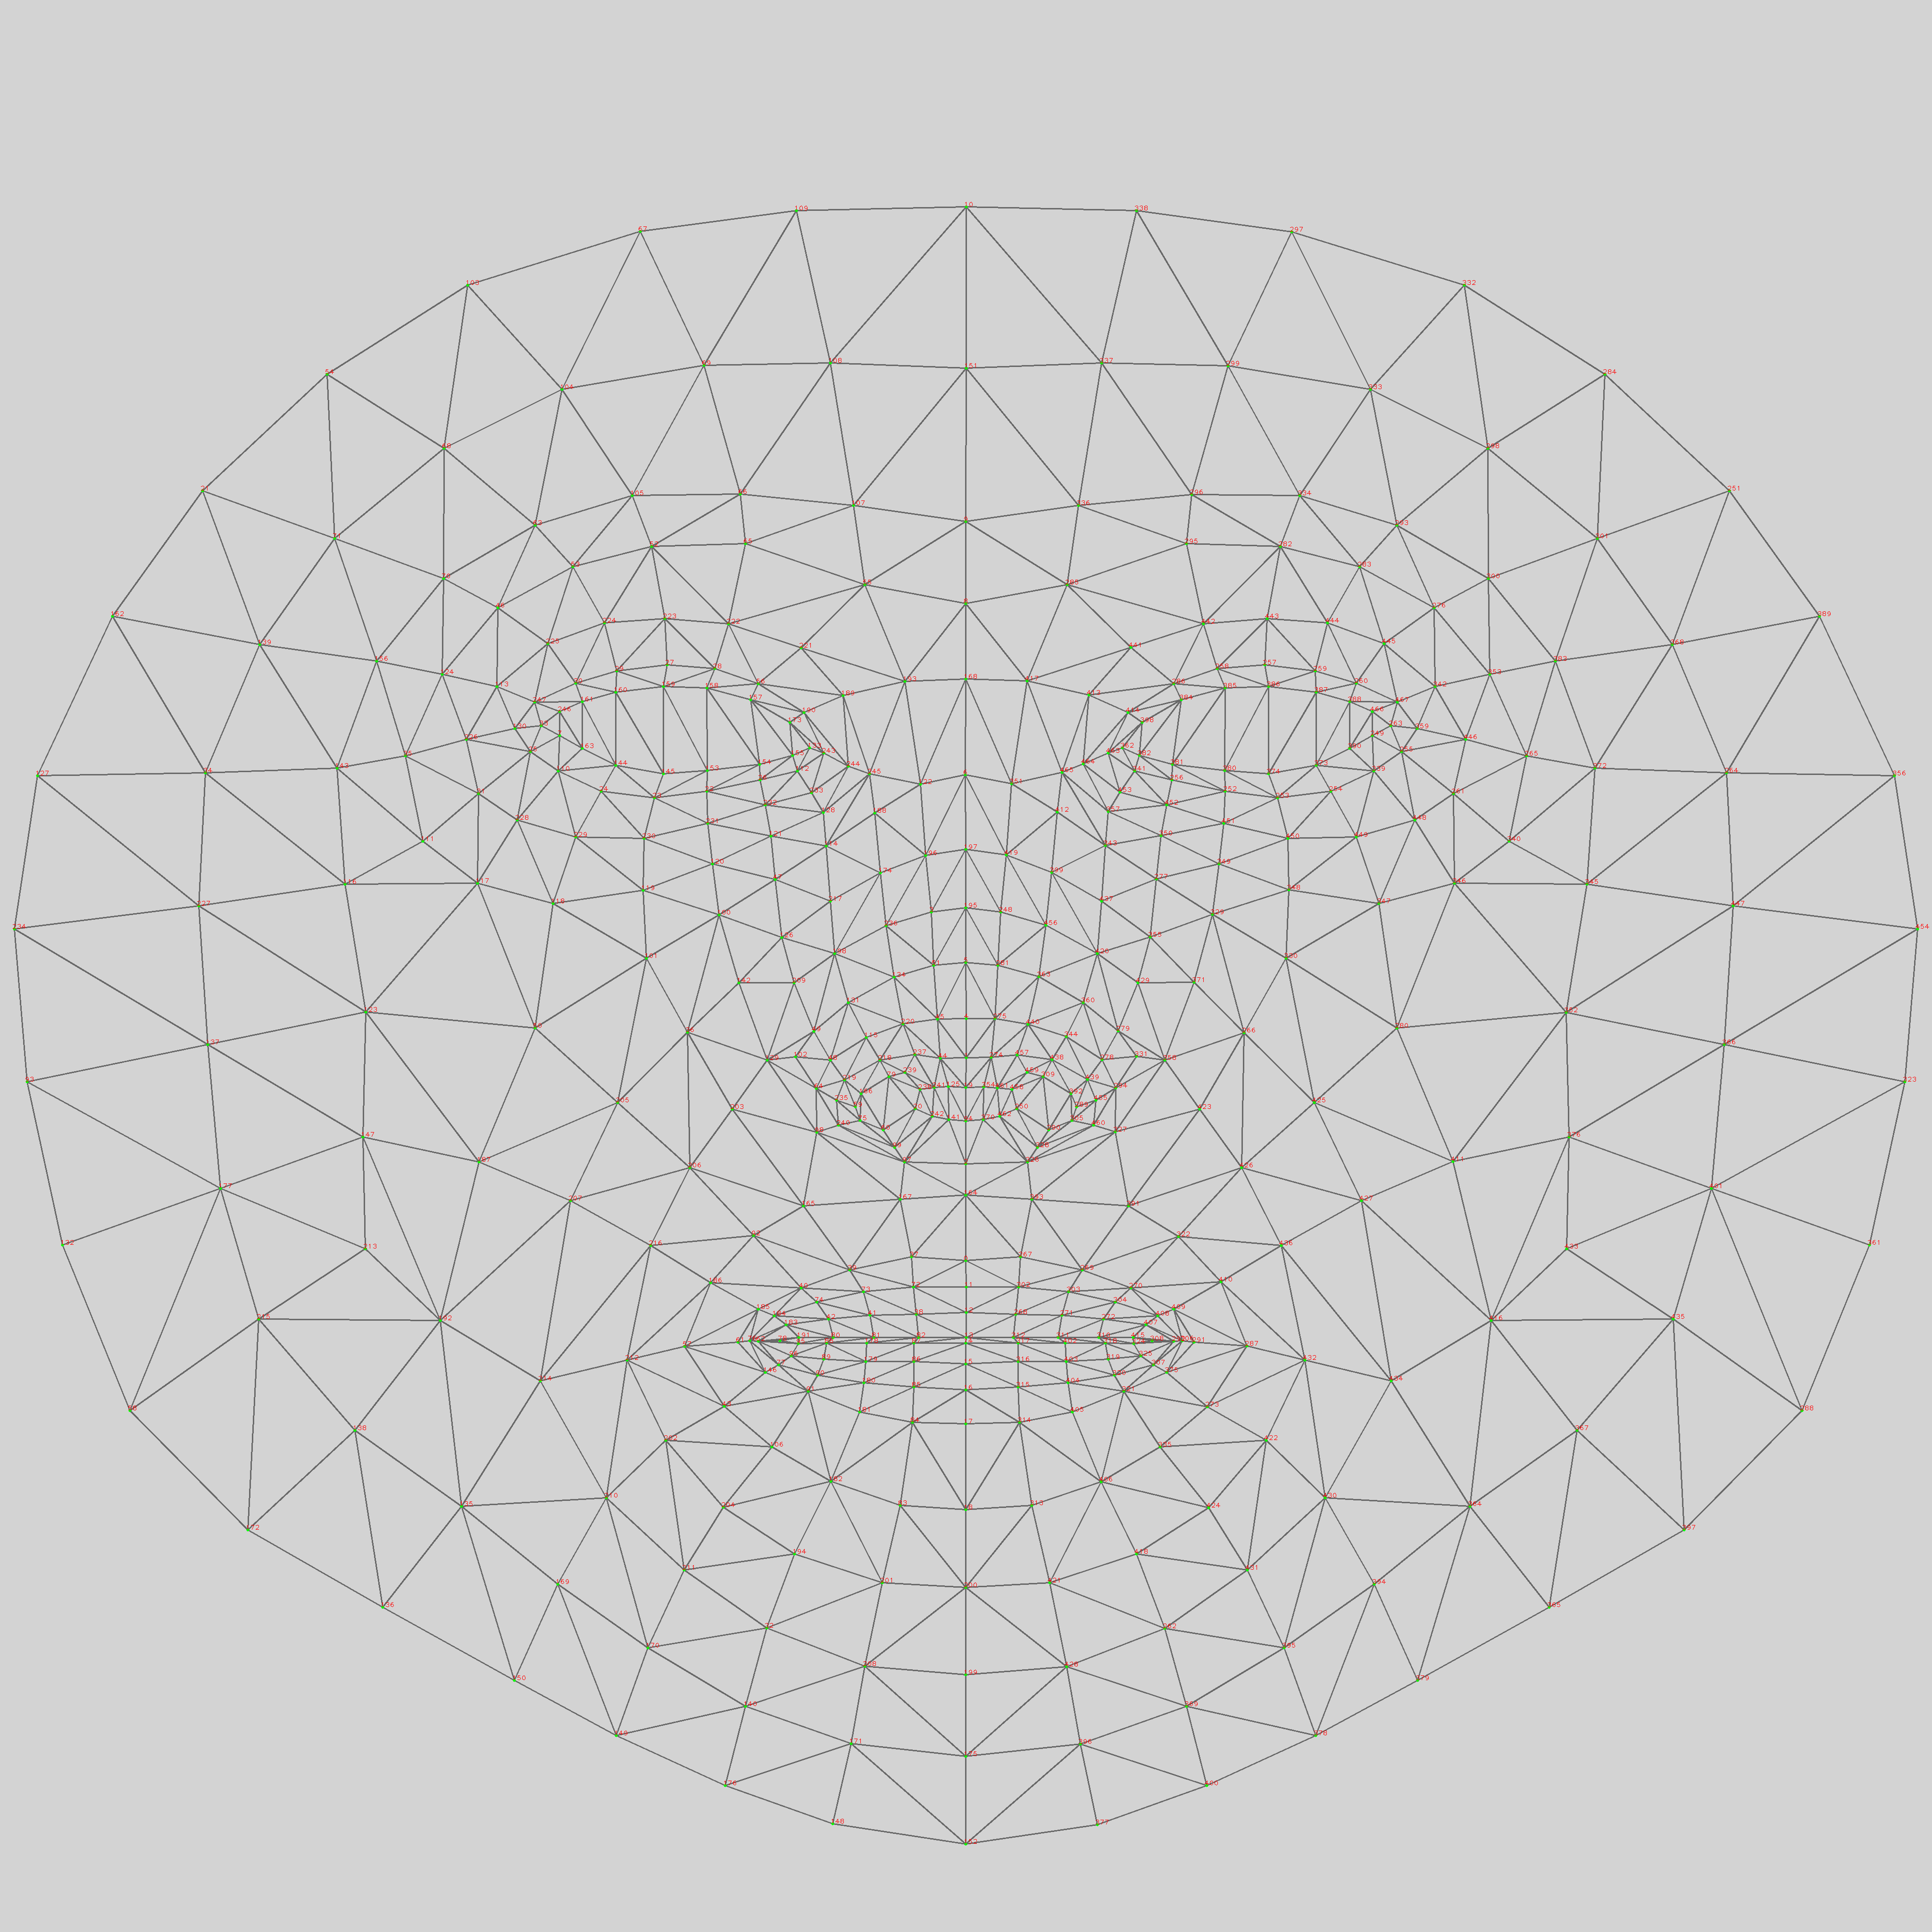

In [5]:
# create new dataframes
left_copy = lh_df.drop(['action', 'video sample number', 'frame number'], axis=1).copy()
rh_copy = rh_df.drop(['action', 'video sample number', 'frame number'], axis=1).copy()
pose_copy = pose_df.drop(['action', 'video sample number', 'frame number'], axis=1).copy()
face_copy = face_df.drop(['action', 'video sample number', 'frame number'], axis=1).copy()

In [6]:
left_copy.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
all_lm = pd.concat([left_copy, rh_copy, pose_copy, face_copy], axis=1)

In [9]:
all_lm.shape

(50400, 1662)

We've been exploring our data in a 2D format but we need to reshape our data back into a 3D numpy array for tensorflow. The array's shape is going to end up being 1260 (total number of video samples) x 40 (total frames per video) x 1662 (total landmarks per frame).

The below function does this for us.

In [10]:
def mat_to_3d(some_df):
    num_of_cols = some_df.shape[1]
    len_of_df = some_df.shape[0]
    my_array = np.zeros((1260, 40, num_of_cols))
    
    for i, j in enumerate(np.arange(0, len_of_df, 40)):
        subset_array = np.arange(j, j+40)
        new_df = some_df.iloc[subset_array]
        my_array[i] = new_df.to_numpy()

    return my_array

In [11]:
# convert back to 3d array
all_lm = mat_to_3d(all_lm)
# sanity check
all_lm.shape

(1260, 40, 1662)

Next i'm just going to quickly create our list of labels for each observation. Each class has 210 observations and are in the same order as below.

In [12]:
# checking order of class labels
label_map.keys()

dict_keys(['finger', 'heart', 'idle', 'kiss', 'salute', 'wave'])

In [13]:
label_map.keys()

dict_keys(['finger', 'heart', 'idle', 'kiss', 'salute', 'wave'])

In [14]:
# create label list for our target variable
labels = []
for action in label_map.keys():
    label_to_append = [action]*210
    labels.append(label_to_append)
labels = np.concatenate(labels)
print(labels.shape)
labels_numerical = np.vectorize(label_map.get)(labels)
print(type(labels_numerical))
print(set(labels_numerical))
print(len(labels_numerical))

(1260,)
<class 'numpy.ndarray'>
{0, 1, 2, 3, 4, 5}
1260


Below cell is to graph our vectorized action images and ensure that they are lining up with their labels. 

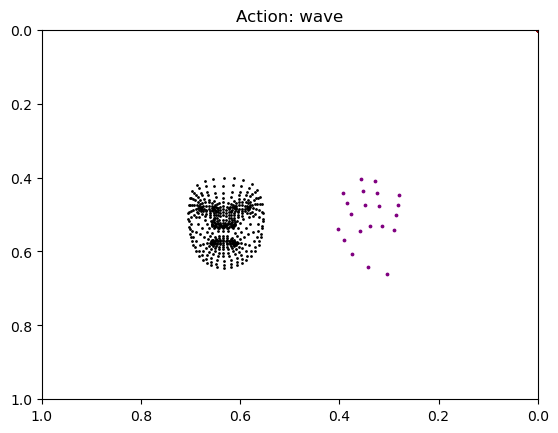

In [15]:
# ENTER VIDEO SAMPLE (BETWEEN 0-1259) TO VISUALIZE LAST FRAME IN VIDEO
vid_sample = 1259

# sanity check function. Enter vid sample to plot action and print label
def plot_action(df, row_num):
    df = df[row_num][39]
    
    # plot face
    face_x = df[np.arange(258, 1662, 3)]
    face_y = df[np.arange(259, 1662, 3)]
    plt.scatter(face_x, face_y, color='black', s=1)
    # plot left hand
    lh_x = df[np.arange(0, 62, 3)] 
    lh_y = df[np.arange(1, 62, 3)]
    plt.scatter(lh_x, lh_y, color='darkred', s=3)
    # plot right hand
    rh_x = df[np.arange(63, 126, 3)]
    rh_y = df[np.arange(64, 126, 3)]
    plt.scatter(rh_x, rh_y, color='purple', s=3)
    


plt.figure()
plot_action(all_lm, vid_sample)
plt.title('Action: {}'.format(labels[vid_sample]))
plt.ylim(0,1)
plt.xlim(0,1)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.show()

#### Modelling

Tensorflow creates it's own validation data during training so we only need to create the train and test partitions.

In [33]:
# Need to change labels_numerical to shape 1260x6
target_labels = to_categorical(labels_numerical).astype(int)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(all_lm, target_labels, random_state=93, test_size=0.2)

In [34]:
print(X_train_1.shape)
print(y_train_1.shape)
print(all_lm[0].shape[0], all_lm[0].shape[1])

(1008, 40, 1662)
(1008, 6)
40 1662


In [35]:
y_train_1.shape

(1008, 6)

In [36]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [37]:
# Instantiate Sequential neural network
clf_model_1 = Sequential()
# Add first LSTM layer with sample input shape - each video observation has 40 frames with 1662 landmark values
clf_model_1.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(all_lm[0].shape[0], all_lm[0].shape[1])))
# Add second LSTM layer
clf_model_1.add(LSTM(128, return_sequences=True, activation='relu'))
# Add third LSTM layer
clf_model_1.add(LSTM(64, return_sequences=False, activation='relu'))
# Add fourth layer (Dense)
clf_model_1.add(Dense(64, activation='relu'))
# Add fifth dense layer
clf_model_1.add(Dense(32, activation='relu'))
# Add final dense layer with softmax activation function to provide predictions
clf_model_1.add(Dense(6, activation='softmax'))

In [38]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
clf_model_1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['categorical_accuracy'])
clf_model_1.fit(X_train_1, y_train_1, epochs=100, callbacks=[tb_callback])

Epoch 1/100
32/32 [==============================] - 4s 62ms/step - loss: 1.7440 - categorical_accuracy: 0.3165
Epoch 2/100
32/32 [==============================] - 2s 63ms/step - loss: 1.5673 - categorical_accuracy: 0.4008
Epoch 3/100
32/32 [==============================] - 2s 63ms/step - loss: 1.3739 - categorical_accuracy: 0.4573
Epoch 4/100
32/32 [==============================] - 2s 63ms/step - loss: 1.2284 - categorical_accuracy: 0.5050
Epoch 5/100
32/32 [==============================] - 2s 63ms/step - loss: 1.1169 - categorical_accuracy: 0.5337
Epoch 6/100
32/32 [==============================] - 2s 63ms/step - loss: 1.0983 - categorical_accuracy: 0.5357
Epoch 7/100
32/32 [==============================] - 2s 64ms/step - loss: 1.0827 - categorical_accuracy: 0.5536
Epoch 8/100
32/32 [==============================] - 2s 63ms/step - loss: 1.0719 - categorical_accuracy: 0.5615
Epoch 9/100
32/32 [==============================] - 2s 64ms/step - loss: 0.9885 - categorical_accuracy:

32/32 [==============================] - 2s 63ms/step - loss: 0.2027 - categorical_accuracy: 0.9167
Epoch 74/100
32/32 [==============================] - 2s 64ms/step - loss: 0.1697 - categorical_accuracy: 0.9315
Epoch 75/100
32/32 [==============================] - 2s 63ms/step - loss: 0.1439 - categorical_accuracy: 0.9454
Epoch 76/100
32/32 [==============================] - 2s 63ms/step - loss: 0.3336 - categorical_accuracy: 0.8899
Epoch 77/100
32/32 [==============================] - 2s 63ms/step - loss: 0.1913 - categorical_accuracy: 0.9236
Epoch 78/100
32/32 [==============================] - 2s 64ms/step - loss: 0.1587 - categorical_accuracy: 0.9454
Epoch 79/100
32/32 [==============================] - 2s 63ms/step - loss: 0.1157 - categorical_accuracy: 0.9643
Epoch 80/100
32/32 [==============================] - 2s 64ms/step - loss: 0.1273 - categorical_accuracy: 0.9504
Epoch 81/100
32/32 [==============================] - 2s 63ms/step - loss: 0.0974 - categorical_accuracy: 0.9

First time training the model the epochs was set to 100. This seems to be too many epochs as the model started to overfit at Epoch 42. Overfitting in a neural network is charactized by the accuracy rising steadly, with the loss function simultaneously decreasing, before both meterics reverse sharply. We see that accuracy plateaus somewhere at Epoch 47 and crashed quickly afterwards. Let's set our Epochs to 50 and see how the model performs.

In [39]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
clf_model_1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['categorical_accuracy'])
clf_model_1.fit(X_train_1, y_train_1, epochs=50, callbacks=[tb_callback])

Epoch 1/50
32/32 [==============================] - 4s 68ms/step - loss: 0.2105 - categorical_accuracy: 0.9246
Epoch 2/50
32/32 [==============================] - 2s 70ms/step - loss: 0.1561 - categorical_accuracy: 0.9385
Epoch 3/50
32/32 [==============================] - 2s 72ms/step - loss: 0.1150 - categorical_accuracy: 0.9603
Epoch 4/50
32/32 [==============================] - 2s 72ms/step - loss: 0.1594 - categorical_accuracy: 0.9375
Epoch 5/50
32/32 [==============================] - 3s 79ms/step - loss: 0.2250 - categorical_accuracy: 0.9167
Epoch 6/50
32/32 [==============================] - 2s 68ms/step - loss: 0.1306 - categorical_accuracy: 0.9554
Epoch 7/50
32/32 [==============================] - 2s 69ms/step - loss: 0.1016 - categorical_accuracy: 0.9663
Epoch 8/50
32/32 [==============================] - 2s 68ms/step - loss: 0.0739 - categorical_accuracy: 0.9792
Epoch 9/50
32/32 [==============================] - 2s 69ms/step - loss: 0.1443 - categorical_accuracy: 0.9484
E

After 50 epochs our model is achieving ~91-92% accuracy, much better.

Let's see how it performs on our test data. 

In [40]:
label_map

{'finger': 0, 'heart': 1, 'idle': 2, 'kiss': 3, 'salute': 4, 'wave': 5}

In [41]:
def get_label_string(predicted_label):
    return list(label_map.keys())[list(label_map.values()).index(predicted_label)]

In [42]:
get_label_string(0)

'finger'

In [43]:
yhat = clf_model_1.predict(X_test_1)
ytrue = np.argmax(y_test_1, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
ytruelabels = [get_label_string(x) for x in yhat]

cf_matrix = confusion_matrix(ytrue, yhat)
print('accuracy score of {}'.format(accuracy_score(ytrue, yhat), ))

8/8 [==============================] - 0s 21ms/step
accuracy score of 0.9007936507936508


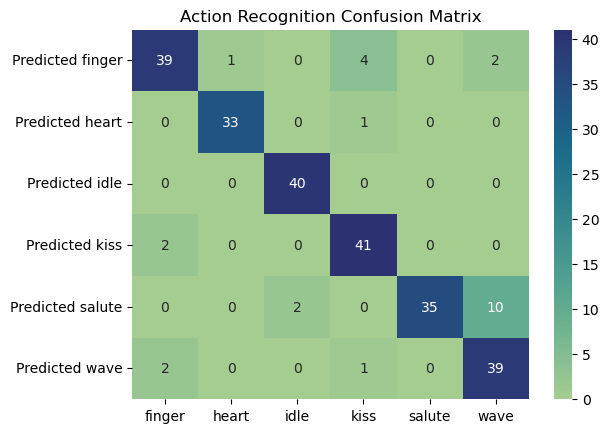

In [44]:
cf_df = pd.DataFrame(
    cf_matrix, columns=label_map.keys(),
    index = [('Predicted ' + x) for x in label_map.keys()]
)

plt.figure()
plt.title('Action Recognition Confusion Matrix')
sns.heatmap(cf_df, annot=True, cmap='crest')
plt.show()

In [45]:
print('Overall micro precision for first lstm model is: {}'.format(precision_score(ytrue, yhat, average='micro')))
print('Overall macro precision for first lstm model is: {}'.format(precision_score(ytrue, yhat, average='macro')))
print('Per class precision is: {}'.format(precision_score(ytrue, yhat, average=None)))
print('Overall micro recall for first lstm model is: {}'.format(recall_score(ytrue, yhat, average='micro')))
print('Overall macro recall for first lstm model is: {}'.format(recall_score(ytrue, yhat, average='macro')))
print('Per class recall is: {}'.format(recall_score(ytrue, yhat, average=None)))

Overall micro precision for first lstm model is: 0.9007936507936508
Overall macro precision for first lstm model is: 0.9111653732909955
Per class precision is: [0.90697674 0.97058824 0.95238095 0.87234043 1.         0.76470588]
Overall micro recall for first lstm model is: 0.9007936507936508
Overall macro recall for first lstm model is: 0.9075258289964868
Per class recall is: [0.84782609 0.97058824 1.         0.95348837 0.74468085 0.92857143]


Our first LSTM model has a validation accuracy of around ~92% and test accuracy of ~90%. The high accuracy score demonstrates that the model is fairly robust and generalizes well on unseen data. In other words, it has learned well from the training data but is not overfitting. The model has great overall precision and recall with both scores around ~90%. This means that it is able to **identify** when an action is being performed and classify it **correctly**.  

The one concerning gesture is the finger class. This class has the highest rate of false positives and false negatives out of all of the classes. In particular, the model has a hard time determining the finger from the wave and kiss actions. When we look at our class specific precision and recalls, we see that the finger only has a 79% precision and 43% recall scores which are substantially lower than our model's overall 90% scores.


The heart and idle classes are being picked up by the model the best.

Before we try and fix the finger gesture, let's see if we can reduce the complexity of the model by removing some features. In the exploratory data analysis we saw that the face landmarks have extremely little variation throughout any of the actions. This means that the face landmark locations should not be particularly useful as an explanitory variable. Since the largest landmark group that we have is the face group, let's just go ahead and just drop all of these landmarks and see how our model performs. Remember that our pose group contains a few landmarks that are located on the face. These should be more than enough face landmarks.

## LSTM Neural Network - Landmark Location Data, No Face Landmarks

In [46]:
# only take left hand, right hand, and pose landmarks
no_face_lm = pd.concat([left_copy, rh_copy, pose_copy], axis=1)
print(no_face_lm.shape)

# convert back to 3d array
no_face_lm = mat_to_3d(no_face_lm)

# sanity check
print(no_face_lm.shape)

(50400, 258)
(1260, 40, 258)


In [47]:
# train test split - target labels remain the same. Only thing we've done is removed features so only need to update
# X dataframe (no_face_lm in this case)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(no_face_lm, target_labels, random_state=93, test_size=0.2)

In [48]:
# Instantiate Sequential neural network
clf_model_2 = Sequential()
# Add first LSTM layer with sample input shape - each video observation has 40 frames with 1662 landmark values
clf_model_2.add(LSTM(64, return_sequences=True, activation='relu', 
                     input_shape=(no_face_lm[0].shape[0], no_face_lm[0].shape[1])))
# Add second LSTM layer
clf_model_2.add(LSTM(128, return_sequences=True, activation='relu'))
# Add third LSTM layer
clf_model_2.add(LSTM(64, return_sequences=False, activation='relu'))
# Add fourth layer (Dense)
clf_model_2.add(Dense(64, activation='relu'))
# Add fifth dense layer
clf_model_2.add(Dense(32, activation='relu'))
# Add final dense layer with softmax activation function to provide predictions
clf_model_2.add(Dense(6, activation='softmax'))

In [49]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
clf_model_2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['categorical_accuracy'])
clf_model_2.fit(X_train_2, y_train_2, epochs=50, callbacks=[tb_callback])

Epoch 1/50
32/32 [==============================] - 3s 35ms/step - loss: 1.7620 - categorical_accuracy: 0.1865
Epoch 2/50
32/32 [==============================] - 1s 35ms/step - loss: 1.5696 - categorical_accuracy: 0.3849
Epoch 3/50
32/32 [==============================] - 1s 35ms/step - loss: 1.4352 - categorical_accuracy: 0.4742
Epoch 4/50
32/32 [==============================] - 1s 38ms/step - loss: 1.2088 - categorical_accuracy: 0.5496
Epoch 5/50
32/32 [==============================] - 2s 50ms/step - loss: 1.0856 - categorical_accuracy: 0.5913
Epoch 6/50
32/32 [==============================] - 1s 39ms/step - loss: 0.9970 - categorical_accuracy: 0.6091
Epoch 7/50
32/32 [==============================] - 1s 38ms/step - loss: 0.8623 - categorical_accuracy: 0.6845
Epoch 8/50
32/32 [==============================] - 1s 39ms/step - loss: 0.7623 - categorical_accuracy: 0.7212
Epoch 9/50
32/32 [==============================] - 2s 48ms/step - loss: 0.7403 - categorical_accuracy: 0.7113
E

In [50]:
yhat2 = clf_model_2.predict(X_test_2)
ytrue2 = np.argmax(y_test_2, axis=1).tolist()
yhat2 = np.argmax(yhat2, axis=1).tolist()
ytruelabels2 = [get_label_string(x) for x in yhat2]

cf_matrix = confusion_matrix(ytrue2, yhat2)
print('accuracy score of {}'.format(accuracy_score(ytrue2, yhat2), ))

8/8 [==============================] - 0s 16ms/step
accuracy score of 0.39285714285714285


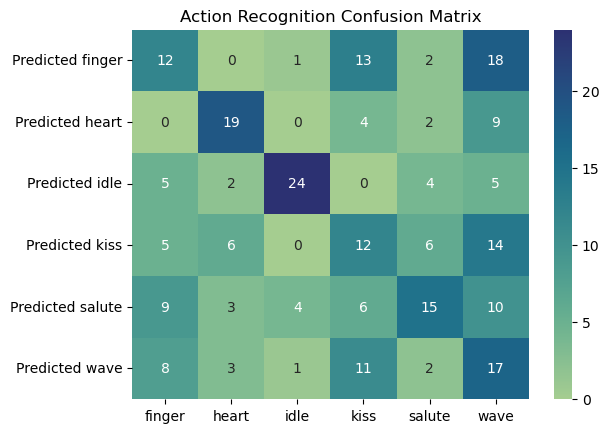

In [51]:
cf_df = pd.DataFrame(
    cf_matrix, columns=label_map.keys(),
    index = [('Predicted ' + x) for x in label_map.keys()]
)

plt.figure()
plt.title('Action Recognition Confusion Matrix')
sns.heatmap(cf_df, annot=True, cmap='crest')
plt.show()

In [52]:
print('Overall micro precision for first lstm model is: {}'.format(precision_score(ytrue, yhat, average='micro')))
print('Overall macro precision for first lstm model is: {}'.format(precision_score(ytrue, yhat, average='macro')))
print('Per class precision is: {}'.format(precision_score(ytrue, yhat, average=None)))
print('Overall micro recall for first lstm model is: {}'.format(recall_score(ytrue, yhat, average='micro')))
print('Overall macro recall for first lstm model is: {}'.format(recall_score(ytrue, yhat, average='macro')))
print('Per class recall is: {}'.format(recall_score(ytrue, yhat, average=None)))

Overall micro precision for first lstm model is: 0.9007936507936508
Overall macro precision for first lstm model is: 0.9111653732909955
Per class precision is: [0.90697674 0.97058824 0.95238095 0.87234043 1.         0.76470588]
Overall micro recall for first lstm model is: 0.9007936507936508
Overall macro recall for first lstm model is: 0.9075258289964868
Per class recall is: [0.84782609 0.97058824 1.         0.95348837 0.74468085 0.92857143]


By removing the face mesh landmarks we have decreased our models complexity from 1662 features to only 258. Not only has this made the model less computationally expensive but we actually see a slight increase in overall accuracy to 91.6%! The overall precision and recall for the model are both high at ~90%. Let's continue pulling on this thread and see how many features we can remove without losing predictive power. As we saw from the EDA, the wrist landmarks capture the most hand movement throughout the actions. Since the pose landmark grouping also has wrist landmarks, let's only use the pose group and see how we the model performs!

We also see that the finger gesture continues to be dragging down the model's performance. In particular, the model is over predicting the finger gesture especially for the wave and kiss actions. We'll try and fix this shortly.

## LSTM Neural Network - Pose Only Landmarks

In [53]:
# Copy pose data in case I want to alter it 
pose_model_lm = pose_copy.copy()
print(pose_model_lm.shape)

# convert back to 3d array
pose_model_lm = mat_to_3d(pose_model_lm)

# sanity check
print(pose_model_lm.shape)

(50400, 132)
(1260, 40, 132)


In [54]:
# train test split - target labels remain the same. Only thing we've done is removed features so only need to update
# X dataframe (pose_model_lm in this case)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(pose_model_lm, target_labels, random_state=93, test_size=0.2)

In [55]:
# Instantiate Sequential neural network
clf_model_3 = Sequential()
# Add first LSTM layer with sample input shape - each video observation has 40 frames with 1662 landmark values
clf_model_3.add(LSTM(64, return_sequences=True, activation='relu', 
                     input_shape=(pose_model_lm[0].shape[0], pose_model_lm[0].shape[1])))
# Add second LSTM layer
clf_model_3.add(LSTM(128, return_sequences=True, activation='relu'))
# Add third LSTM layer
clf_model_3.add(LSTM(64, return_sequences=False, activation='relu'))
# Add fourth layer (Dense)
clf_model_3.add(Dense(64, activation='relu'))
# Add fifth dense layer
clf_model_3.add(Dense(32, activation='relu'))
# Add final dense layer with softmax activation function to provide predictions
clf_model_3.add(Dense(6, activation='softmax'))

In [56]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
clf_model_3.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['categorical_accuracy'])
clf_model_3.fit(X_train_3, y_train_3, epochs=50, callbacks=[tb_callback])

Epoch 1/50
32/32 [==============================] - 4s 35ms/step - loss: 1.7654 - categorical_accuracy: 0.2292
Epoch 2/50
32/32 [==============================] - 1s 34ms/step - loss: 1.5386 - categorical_accuracy: 0.2877
Epoch 3/50
32/32 [==============================] - 1s 37ms/step - loss: 1.4281 - categorical_accuracy: 0.5020
Epoch 4/50
32/32 [==============================] - 1s 40ms/step - loss: 1.0959 - categorical_accuracy: 0.5863
Epoch 5/50
32/32 [==============================] - 1s 43ms/step - loss: 0.9640 - categorical_accuracy: 0.6141
Epoch 6/50
32/32 [==============================] - 1s 38ms/step - loss: 0.8246 - categorical_accuracy: 0.6607
Epoch 7/50
32/32 [==============================] - 1s 34ms/step - loss: 0.7670 - categorical_accuracy: 0.6925
Epoch 8/50
32/32 [==============================] - 1s 35ms/step - loss: 0.6900 - categorical_accuracy: 0.7292
Epoch 9/50
32/32 [==============================] - 1s 34ms/step - loss: 0.6052 - categorical_accuracy: 0.7500
E

In [57]:
yhat3 = clf_model_3.predict(X_test_3)
ytrue3 = np.argmax(y_test_3, axis=1).tolist()
yhat3 = np.argmax(yhat3, axis=1).tolist()
ytruelabels3 = [get_label_string(x) for x in yhat3]

cf_matrix = confusion_matrix(ytrue3, yhat3)
print('accuracy score of {}'.format(accuracy_score(ytrue3, yhat3)))

8/8 [==============================] - 0s 12ms/step
accuracy score of 0.7817460317460317


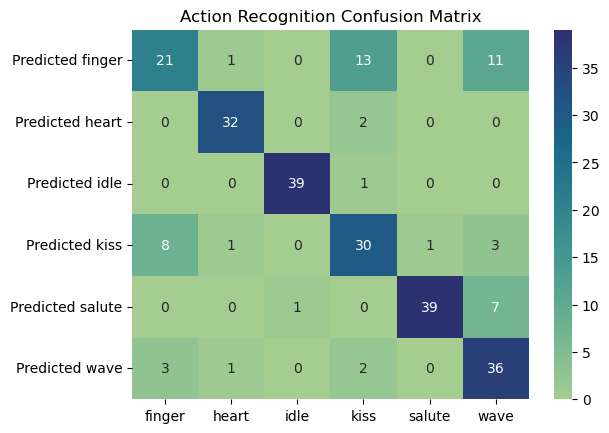

In [60]:
cf_df = pd.DataFrame(
    cf_matrix, columns=label_map.keys(),
    index = [('Predicted ' + x) for x in label_map.keys()]
)

plt.figure()
plt.title('Action Recognition Confusion Matrix')
sns.heatmap(cf_df, annot=True, cmap='crest')
plt.show()

In [61]:
print('Overall micro precision for first lstm model is: {}'.format(precision_score(ytrue3, yhat3, average='micro')))
print('Overall macro precision for first lstm model is: {}'.format(precision_score(ytrue3, yhat3, average='macro')))
print('Per class precision is: {}'.format(precision_score(ytrue3, yhat3, average=None)))
print('Overall micro recall for first lstm model is: {}'.format(recall_score(ytrue3, yhat3, average='micro')))
print('Overall macro recall for first lstm model is: {}'.format(recall_score(ytrue3, yhat3, average='macro')))
print('Per class recall is: {}'.format(recall_score(ytrue3, yhat3, average=None)))

Overall micro precision for first lstm model is: 0.7817460317460317
Overall macro precision for first lstm model is: 0.7961857769423558
Per class precision is: [0.65625    0.91428571 0.975      0.625      0.975      0.63157895]
Overall micro recall for first lstm model is: 0.7817460317460317
Overall macro recall for first lstm model is: 0.7928837865847885
Per class recall is: [0.45652174 0.94117647 0.975      0.69767442 0.82978723 0.85714286]


Okay we are seeing quite a lot of decrease in our model's performance by removing the hands! Looks like the extra hand landmarks are very important to keep and the model is performing worse across the board. The finger action remains the hardest to separate and we will look to fix that in the next section.

## LSTM Neural Network 4 - Pose, Hand, & Distance Data

In the next model I've engineered some new distance features in order to better separate the finger action from the other actions. When we graphed the how the distance between the tip of the middle finger and wrist changes over the different sequences, we get a very distinguishable signal for the finger action. I'm hoping that these additional features will help model performance. 

In [65]:
# create distance copy
dist_copy = lm_distances.drop(['action', 'video sample number', 'frame number'], axis=1).copy()
# only take left hand, right hand, and pose landmarks
X_dist = pd.concat([left_copy, rh_copy, pose_copy, dist_copy], axis=1)
print(X_dist.shape)

# convert back to 3d array
X_dist = mat_to_3d(X_dist)

# sanity check
print(X_dist.shape)

(50400, 279)
(1260, 40, 279)


In [66]:
# train test split - target labels remain the same. Only thing we've done is removed features so only need to update
# X dataframe (no_face_lm in this case)

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_dist, target_labels, random_state=93, test_size=0.2)

In [67]:
# Instantiate Sequential neural network
clf_model_4 = Sequential()
# Add first LSTM layer with sample input shape - each video observation has 40 frames with 1662 landmark values
clf_model_4.add(LSTM(64, return_sequences=True, activation='relu', 
                     input_shape=(X_dist[0].shape[0], X_dist[0].shape[1])))
# Add second LSTM layer
clf_model_4.add(LSTM(128, return_sequences=True, activation='relu'))
# Add third LSTM layer
clf_model_4.add(LSTM(64, return_sequences=False, activation='relu'))
# Add fourth layer (Dense)
clf_model_4.add(Dense(64, activation='relu'))
# Add fifth dense layer
clf_model_4.add(Dense(32, activation='relu'))
# Add final dense layer with softmax activation function to provide predictions
clf_model_4.add(Dense(6, activation='softmax'))

In [68]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
clf_model_4.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['categorical_accuracy'])
clf_model_4.fit(X_train_4, y_train_4, epochs=50, callbacks=[tb_callback])

Epoch 1/50
32/32 [==============================] - 3s 35ms/step - loss: 1.7289 - categorical_accuracy: 0.2688
Epoch 2/50
32/32 [==============================] - 1s 35ms/step - loss: 1.4381 - categorical_accuracy: 0.4752
Epoch 3/50
32/32 [==============================] - 1s 35ms/step - loss: 1.0528 - categorical_accuracy: 0.5853
Epoch 4/50
32/32 [==============================] - 1s 35ms/step - loss: 0.8806 - categorical_accuracy: 0.6518
Epoch 5/50
32/32 [==============================] - 1s 35ms/step - loss: 0.8684 - categorical_accuracy: 0.6786
Epoch 6/50
32/32 [==============================] - 1s 35ms/step - loss: 0.6585 - categorical_accuracy: 0.7460
Epoch 7/50
32/32 [==============================] - 1s 37ms/step - loss: 0.5593 - categorical_accuracy: 0.7966
Epoch 8/50
32/32 [==============================] - 1s 38ms/step - loss: 0.5037 - categorical_accuracy: 0.8194
Epoch 9/50
32/32 [==============================] - 1s 35ms/step - loss: 0.4310 - categorical_accuracy: 0.8482
E

In [69]:
yhat4 = clf_model_4.predict(X_test_4)
ytrue4 = np.argmax(y_test_4, axis=1).tolist()
yhat4 = np.argmax(yhat4, axis=1).tolist()
ytruelabels4 = [get_label_string(x) for x in yhat4]

cf_matrix = confusion_matrix(ytrue4, yhat4)
print('accuracy score of {}'.format(accuracy_score(ytrue4, yhat4)))

8/8 [==============================] - 0s 14ms/step
accuracy score of 0.9365079365079365


In [72]:
35/(35+1+5+3+2)

0.7608695652173914

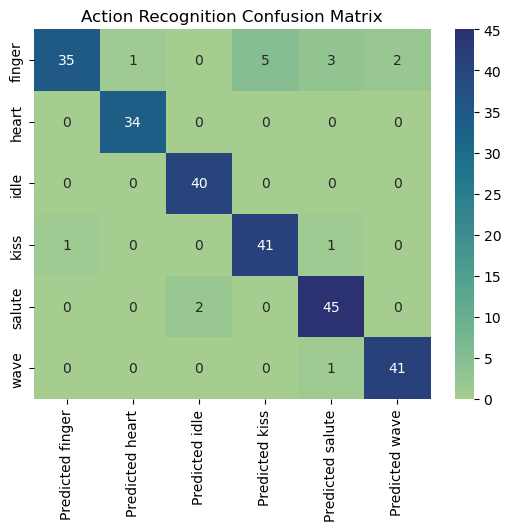

In [75]:
cf_df = pd.DataFrame(
    cf_matrix, index = label_map.keys(),
    columns = [('Predicted ' + y) for y in label_map.keys()]
)

plt.figure()
plt.title('Action Recognition Confusion Matrix')
sns.heatmap(cf_df, annot=True, cmap='crest')
plt.show()

In [73]:
#print('Overall micro precision for first lstm model is: {}'.format(precision_score(ytrue4, yhat4, average='micro')))
#print('Overall macro precision for first lstm model is: {}'.format(precision_score(ytrue4, yhat4, average='macro')))
print('Per class precision is: {}'.format(precision_score(ytrue4, yhat4, average=None)))
#print('Overall micro recall for first lstm model is: {}'.format(recall_score(ytrue4, yhat4, average='micro')))
#print('Overall macro recall for first lstm model is: {}'.format(recall_score(ytrue4, yhat4, average='macro')))
print('Per class recall is: {}'.format(recall_score(ytrue4, yhat4, average=None)))

Per class precision is: [0.97222222 0.97142857 0.95238095 0.89130435 0.9        0.95348837]
Per class recall is: [0.76086957 1.         1.         0.95348837 0.95744681 0.97619048]
